In [52]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample

In [53]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow is using GPU:", tf.test.is_gpu_available())


Num GPUs Available: 1
TensorFlow is using GPU: True


In [54]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Adjust memory as needed
        print("GPU is enabled and configured.")
    except RuntimeError as e:
        print(e)


Physical devices cannot be modified after being initialized


In [55]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
print("TensorFlow is using GPU:", tf.test.is_built_with_cuda())
print("Physical Devices:", tf.config.list_physical_devices('GPU'))


Num GPUs Available: 1
TensorFlow is using GPU: True
Physical Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [56]:
# Define filtering functions
def lowpass_filter(data, cutoff=15, fs=2175, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return filtfilt(b, a, data)

def bandpass_filter(data, lowcut=0.5, highcut=8, fs=30, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [57]:
# Cell 2: Define data augmentation function
def apply_gaussian_noise(signal, noise_std=0.02):
    noise = np.random.normal(0, noise_std, signal.shape)
    return signal + noise

In [58]:
def process_ppg_file(signal_path, label_path, target_sampling_rate=30, augment=False):
    signal_data = pd.read_csv(signal_path, header=None).values.flatten()
    label_data = pd.read_csv(label_path)
    
    filtered_signal = lowpass_filter(signal_data)
    original_sampling_rate = 2175
    num_samples = int(len(filtered_signal) * (target_sampling_rate / original_sampling_rate))
    downsampled_signal = resample(filtered_signal, num_samples)
    processed_signal = bandpass_filter(downsampled_signal, fs=target_sampling_rate)
    processed_signal = (processed_signal - np.mean(processed_signal)) / np.std(processed_signal)
    
    glucose_level = label_data['Glucose'].values[0]
    age = label_data['Age'].values[0]
    gender = 1 if label_data['Gender'].values[0] == 'Male' else 0
    
    augmented_signals = [processed_signal]
    
    if augment:
        for _ in range(3):  # Apply Gaussian noise 3 times per signal
            augmented_signals.append(apply_gaussian_noise(processed_signal))
    
    return [(sig, glucose_level, age, gender) for sig in augmented_signals]


In [59]:
def process_all_ppg_files(root_folder, output_file, augment=False):
    signal_folder = os.path.join(root_folder, "RawData")
    label_folder = os.path.join(root_folder, "Labels")
    
    if not os.path.exists(signal_folder):
        raise FileNotFoundError(f"Error: Signal folder not found at {signal_folder}")
    if not os.path.exists(label_folder):
        raise FileNotFoundError(f"Error: Label folder not found at {label_folder}")
    
    processed_data = []
    
    for signal_file in os.listdir(signal_folder):
        if signal_file.startswith('signal') and signal_file.endswith('.csv'):
            label_file = signal_file.replace('signal', 'label')
            signal_path = os.path.join(signal_folder, signal_file)
            label_path = os.path.join(label_folder, label_file)
            
            if os.path.exists(label_path):
                processed_data.extend(process_ppg_file(signal_path, label_path, augment=augment))
            else:
                print(f"Warning: No matching label file for {signal_file}")
    
    df = pd.DataFrame(processed_data, columns=['PPG_Signal', 'Glucose_Level', 'Age', 'Gender'])
    df.to_pickle(output_file)
    print(f"Processed data saved to {output_file}. Dataset size: {len(df)} samples.")

In [60]:
def plot_ppg_signals(pickle_file, num_samples=5):
    df = pd.read_pickle(pickle_file)
    plt.figure(figsize=(12, 6))
    for i in range(min(num_samples, len(df))):
        ppg_signal = df.iloc[i]["PPG_Signal"]
        plt.plot(ppg_signal, label=f"Sample {i+1} (Glucose: {df.iloc[i]['Glucose_Level']} mg/dL)")
    plt.xlabel("Time (samples at 30Hz)")
    plt.ylabel("Normalized PPG Amplitude")
    plt.title("Visualization of Processed PPG Signals")
    plt.legend()
    plt.show()


Processed data saved to processed_ppg_data.pkl. Dataset size: 268 samples.


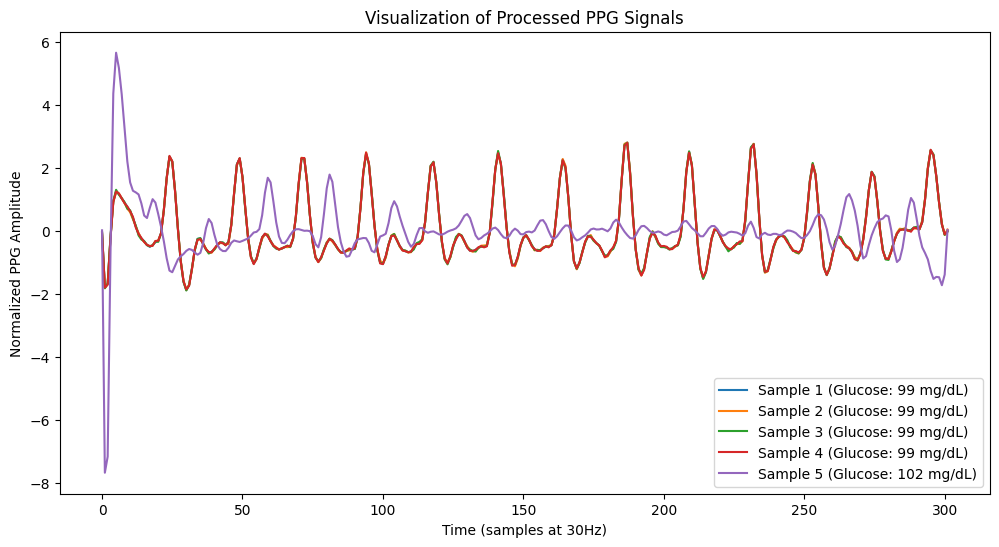

In [61]:
process_all_ppg_files("C:/Users/Tiddie Destroyer/Downloads/PPG_Dataset/PPG_Dataset", "processed_ppg_data.pkl", augment=True)
plot_ppg_signals("processed_ppg_data.pkl")


In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def split_train_test(pickle_file, test_size=0.2, random_state=42):
    df = pd.read_pickle(pickle_file)
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)  # Shuffle dataset
    
    X = np.array(df['PPG_Signal'].tolist())  # Convert list of arrays into a NumPy array
    y = df['Glucose_Level'].values  # Target variable
    
    scaler_X = MinMaxScaler()
    X = scaler_X.fit_transform(X)
    
    scaler_y = MinMaxScaler()
    y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
    return X_train, X_test, y_train, y_test, scaler_y


In [63]:
# Cell 8: Train a Random Forest Model
def train_model(X_train, y_train, n_estimators=100, random_state=42):
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    model.fit(X_train, y_train)
    return model

In [64]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    return mae, rmse

In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

In [66]:
X_train, X_test, y_train, y_test, scaler_y = split_train_test("processed_ppg_data.pkl")
model = train_model(X_train, y_train)
evaluate_model(model, X_test, y_test)

Train set size: 214, Test set size: 54
Mean Absolute Error: 0.03
Root Mean Squared Error: 0.05


(0.030766081871345104, 0.04878125831104559)

In [67]:
def build_optimized_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True, activation='relu'), input_shape=input_shape),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='mse', metrics=['mae'])
    return model

In [68]:
def train_optimized_lstm(X_train, y_train, X_test, y_test, model_path='optimized_lstm_model2.h5', epochs=150, batch_size=32):
    input_shape = (X_train.shape[1], 1)
    X_train = np.expand_dims(X_train, axis=-1)  # Reshape for LSTM
    X_test = np.expand_dims(X_test, axis=-1)
    
    model = build_optimized_lstm_model(input_shape)
    
    early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])
    model.save(model_path)
    print(f"Optimized model saved to {model_path}")
    return model

In [69]:
def evaluate_model(model, X_test, y_test, scaler_y):
    X_test = np.expand_dims(X_test, axis=-1)  # Ensure correct shape for predictions
    y_pred = model.predict(X_test)
    
    # Inverse transform predictions to original glucose scale
    y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    # Compute Metrics
    mae = mean_absolute_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_original, y_pred_original, alpha=0.7, label='Predicted vs Actual')
    plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r', linestyle='--')
    plt.xlabel("Actual Glucose Level")
    plt.ylabel("Predicted Glucose Level")
    plt.title("Predicted vs. Actual Glucose Levels")
    plt.legend()
    plt.show()
    
    return mae, rmse, r2

In [70]:
X_train, X_test, y_train, y_test, scaler_y = split_train_test("processed_ppg_data.pkl")
lstm_model = train_optimized_lstm(X_train, y_train, X_test, y_test)


Train set size: 214, Test set size: 54
Epoch 1/150
7/7 [==============================] - 11s 895ms/step - loss: 0.0929 - mae: 0.2421 - val_loss: 0.1429 - val_mae: 0.2904 - lr: 2.0000e-04
Epoch 2/150
7/7 [==============================] - 5s 729ms/step - loss: 0.0531 - mae: 0.1778 - val_loss: 0.1276 - val_mae: 0.2643 - lr: 2.0000e-04
Epoch 3/150
7/7 [==============================] - 5s 787ms/step - loss: 0.0497 - mae: 0.1789 - val_loss: 0.1201 - val_mae: 0.2509 - lr: 2.0000e-04
Epoch 4/150
7/7 [==============================] - 5s 792ms/step - loss: 0.0415 - mae: 0.1519 - val_loss: 0.1171 - val_mae: 0.2463 - lr: 2.0000e-04
Epoch 5/150
7/7 [==============================] - 5s 788ms/step - loss: 0.0395 - mae: 0.1491 - val_loss: 0.1123 - val_mae: 0.2388 - lr: 2.0000e-04
Epoch 6/150
7/7 [==============================] - 6s 797ms/step - loss: 0.0362 - mae: 0.1451 - val_loss: 0.1103 - val_mae: 0.2361 - lr: 2.0000e-04
Epoch 7/150
7/7 [==============================] - 6s 823ms/step - loss:

2/2 [==============================] - 1s 123ms/step
Mean Absolute Error: 2.79
Root Mean Squared Error: 4.41
R² Score: 0.96


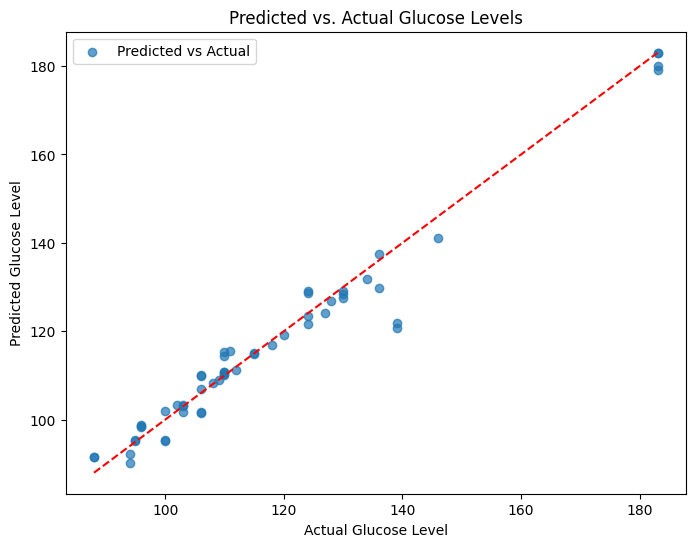

(2.7939156426323772, 4.40516422817893, 0.9638382399968848)

In [71]:
evaluate_model(lstm_model, X_test, y_test, scaler_y)

In [72]:
def build_ensemble_lstm_model(input_shape):
    models = []
    for _ in range(3):  # Create 3 separate LSTM models
        model = Sequential([
            Bidirectional(LSTM(256, return_sequences=True, activation='relu'), input_shape=input_shape),
            Bidirectional(LSTM(128, return_sequences=True)),
            Bidirectional(LSTM(64)),
            BatchNormalization(),
            Dropout(0.1),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1)  # Output layer for regression
        ])
        model.compile(optimizer=Adam(learning_rate=0.0002), loss='mse', metrics=['mae'])
        models.append(model)
    return models


In [73]:
def train_ensemble_lstm(X_train, y_train, X_test, y_test, model_paths=['lstm_model_1.h5', 'lstm_model_2.h5', 'lstm_model_3.h5'], epochs=150, batch_size=32):
    input_shape = (X_train.shape[1], 1)
    X_train = np.expand_dims(X_train, axis=-1)  # Reshape for LSTM
    X_test = np.expand_dims(X_test, axis=-1)
    
    models = build_ensemble_lstm_model(input_shape)
    
    early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
    
    for i, model in enumerate(models):
        print(f"Training model {i+1}...")
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reduce_lr])
        model.save(model_paths[i])
        print(f"Model {i+1} saved to {model_paths[i]}")
    
    return models

In [74]:
def ensemble_predict(models, X_test):
    X_test = np.expand_dims(X_test, axis=-1)
    predictions = np.array([model.predict(X_test) for model in models])
    final_predictions = np.mean(predictions, axis=0)  # Average predictions from all models
    return final_predictions.flatten()

In [75]:
X_train, X_test, y_train, y_test, scaler_y = split_train_test("processed_ppg_data.pkl")
ensemble_models = train_ensemble_lstm(X_train, y_train, X_test, y_test)
y_pred = ensemble_predict(ensemble_models, X_test)

Train set size: 214, Test set size: 54
Training model 1...
Epoch 1/150
7/7 [==============================] - 11s 946ms/step - loss: 0.0762 - mae: 0.2199 - val_loss: 0.1376 - val_mae: 0.2816 - lr: 2.0000e-04
Epoch 2/150
7/7 [==============================] - 6s 858ms/step - loss: 0.0569 - mae: 0.1892 - val_loss: 0.1211 - val_mae: 0.2530 - lr: 2.0000e-04
Epoch 3/150
7/7 [==============================] - 5s 761ms/step - loss: 0.0444 - mae: 0.1596 - val_loss: 0.1133 - val_mae: 0.2392 - lr: 2.0000e-04
Epoch 4/150
7/7 [==============================] - 5s 758ms/step - loss: 0.0399 - mae: 0.1469 - val_loss: 0.1080 - val_mae: 0.2311 - lr: 2.0000e-04
Epoch 5/150
7/7 [==============================] - 6s 775ms/step - loss: 0.0352 - mae: 0.1449 - val_loss: 0.1038 - val_mae: 0.2248 - lr: 2.0000e-04
Epoch 6/150
7/7 [==============================] - 5s 768ms/step - loss: 0.0323 - mae: 0.1322 - val_loss: 0.0992 - val_mae: 0.2174 - lr: 2.0000e-04
Epoch 7/150
7/7 [==============================] - 6

In [81]:
y_pred = ensemble_predict(ensemble_models, X_test)

2/2 [==============================] - 0s 126ms/step


In [82]:
def evaluate_ensemble(models, X_test, y_test, scaler_y):
    y_pred = ensemble_predict(models, X_test)
    y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal line
    plt.xlabel("Actual Glucose Level")
    plt.ylabel("Predicted Glucose Level")
    plt.title("Predicted vs. Actual Glucose Levels")
    plt.legend()
    plt.show()
    
    return mae, rmse, r2


2/2 [==============================] - 0s 120ms/step
Mean Absolute Error: 2.79
Root Mean Squared Error: 3.73
R² Score: 0.97


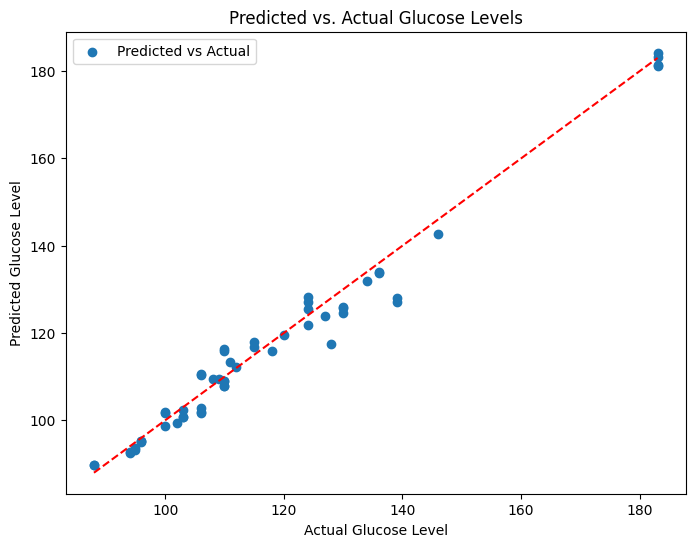

(2.7897454720956296, 3.7307991837242644, 0.9740624412429777)

In [83]:
evaluate_ensemble(ensemble_models, X_test, y_test, scaler_y)

In [109]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

def save_ensemble_model(models, scaler_y, base_path='model_ensemble'):
    """
    Save an ensemble of models along with the scaler used for the target variable.
    
    Parameters:
    -----------
    models : list
        List of Keras models in the ensemble
    scaler_y : object
        The scaler used to transform the target variable
    base_path : str
        Base directory to save all model files
    """
    # Create the directory if it doesn't exist
    os.makedirs(base_path, exist_ok=True)
    
    # Save each model
    model_paths = []
    for i, model in enumerate(models):
        model_path = os.path.join(base_path, f'model_{i+1}.h5')
        model.save(model_path)
        model_paths.append(model_path)
    
    # Save the scaler
    scaler_path = os.path.join(base_path, 'scaler_y.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler_y, f)
    
    # Save metadata about the ensemble
    metadata = {
        'num_models': len(models),
        'model_paths': model_paths,
        'scaler_path': scaler_path
    }
    
    metadata_path = os.path.join(base_path, 'metadata.pkl')
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    
    print(f"Ensemble model saved to {base_path}")
    return metadata_path

def load_ensemble_model(metadata_path):
    """
    Load an ensemble of models along with the scaler used for the target variable.
    
    Parameters:
    -----------
    metadata_path : str
        Path to the metadata file
    
    Returns:
    --------
    models : list
        List of loaded Keras models
    scaler_y : object
        The scaler used to transform the target variable
    """
    # Load metadata
    with open(metadata_path, 'rb') as f:
        metadata = pickle.load(f)
    
    # Load models
    models = []
    for model_path in metadata['model_paths']:
        model = load_model(model_path)
        models.append(model)
    
    # Load scaler
    with open(metadata['scaler_path'], 'rb') as f:
        scaler_y = pickle.load(f)
    
    print(f"Loaded ensemble with {len(models)} models")
    return models, scaler_y


In [110]:
def predict_glucose_levels(ppg_data, models, scaler_y):
    """
    Make predictions using the loaded ensemble model.
    
    Parameters:
    -----------
    ppg_data : numpy.ndarray
        Preprocessed PPG signal data
    models : list
        List of loaded Keras models
    scaler_y : object
        The scaler used to transform the target variable
    
    Returns:
    --------
    predictions : numpy.ndarray
        Predicted glucose levels
    """
    # Ensure data is properly shaped for LSTM
    if len(ppg_data.shape) == 2:
        ppg_data = np.expand_dims(ppg_data, axis=-1)
    
    # Make predictions with each model in the ensemble
    predictions = np.array([model.predict(ppg_data) for model in models])
    
    # Average predictions from all models
    final_predictions = np.mean(predictions, axis=0)
    
    # Inverse transform to get actual glucose levels
    glucose_levels = scaler_y.inverse_transform(final_predictions)
    
    return glucose_levels.flatten()

In [111]:
# After your training is complete
X_train, X_test, y_train, y_test, scaler_y = split_train_test("processed_ppg_data.pkl")
ensemble_models = train_ensemble_lstm(X_train, y_train, X_test, y_test)

# Save the complete ensemble
metadata_path = save_ensemble_model(ensemble_models, scaler_y, base_path='glucose_ensemble')

Train set size: 214, Test set size: 54
Training model 1...
Epoch 1/150
7/7 [==============================] - 12s 972ms/step - loss: 0.0842 - mae: 0.2210 - val_loss: 0.1334 - val_mae: 0.2747 - lr: 2.0000e-04
Epoch 2/150
7/7 [==============================] - 5s 784ms/step - loss: 0.0539 - mae: 0.1826 - val_loss: 0.1152 - val_mae: 0.2436 - lr: 2.0000e-04
Epoch 3/150
7/7 [==============================] - 5s 788ms/step - loss: 0.0425 - mae: 0.1614 - val_loss: 0.1096 - val_mae: 0.2347 - lr: 2.0000e-04
Epoch 4/150
7/7 [==============================] - 5s 747ms/step - loss: 0.0409 - mae: 0.1544 - val_loss: 0.1061 - val_mae: 0.2291 - lr: 2.0000e-04
Epoch 5/150
7/7 [==============================] - 5s 756ms/step - loss: 0.0369 - mae: 0.1453 - val_loss: 0.0971 - val_mae: 0.2153 - lr: 2.0000e-04
Epoch 6/150
7/7 [==============================] - 5s 775ms/step - loss: 0.0331 - mae: 0.1387 - val_loss: 0.0950 - val_mae: 0.2116 - lr: 2.0000e-04
Epoch 7/150
7/7 [==============================] - 6

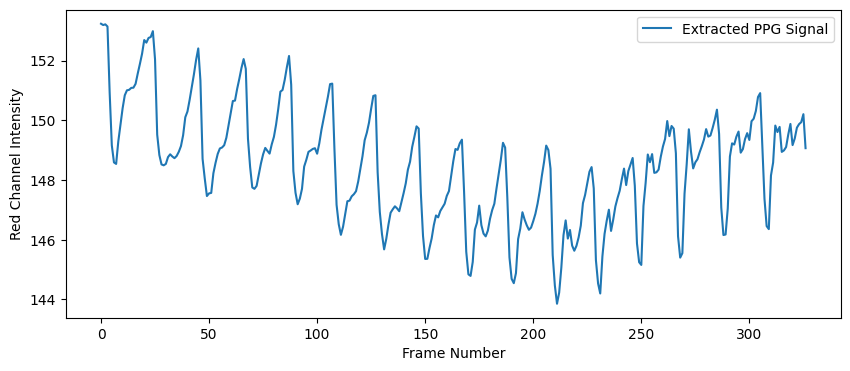

In [581]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the recorded video
cap = cv2.VideoCapture("PPG_Unseen/PPG17.mp4")
red_channel_values = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # Extract the red channel (assuming OpenCV loads as BGR)
    red_channel = frame[:, :, 2]
    avg_intensity = np.mean(red_channel)
    red_channel_values.append(avg_intensity)

cap.release()

# Convert to NumPy array
ppg_signal = np.array(red_channel_values)

# Plot the extracted PPG signal
plt.figure(figsize=(10, 4))
plt.plot(ppg_signal, label="Extracted PPG Signal")
plt.xlabel("Frame Number")
plt.ylabel("Red Channel Intensity")
plt.legend()
plt.show()


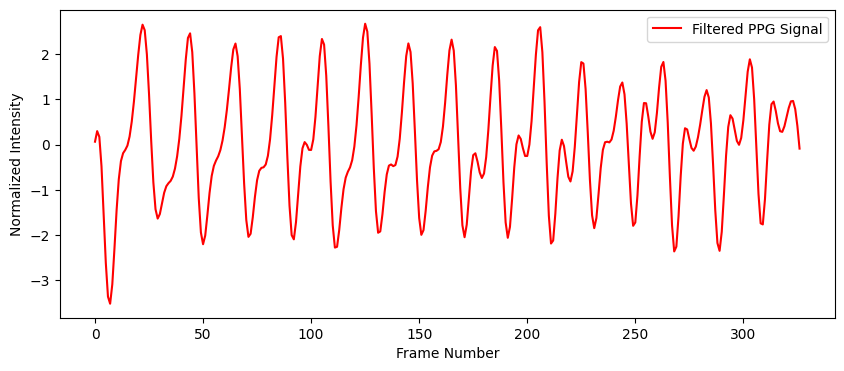

In [582]:
from scipy.signal import butter, filtfilt

# Apply bandpass filter (0.5 - 4 Hz to match heart rate range)
def bandpass_filter(signal, lowcut=0.5, highcut=4.0, fs=30, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Assume a 30 Hz sampling rate (approximate for phone cameras)
filtered_ppg = bandpass_filter(ppg_signal, fs=30)

# Plot filtered signal
plt.figure(figsize=(10, 4))
plt.plot(filtered_ppg, label="Filtered PPG Signal", color='red')
plt.xlabel("Frame Number")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.show()


In [583]:
# def moving_average(signal, window_size=5):
#     return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

# # Apply moving average
# smoothed_ppg = moving_average(ppg_bandpassed, window_size=5)

# # Plot smoothed signal
# plt.figure(figsize=(10, 4))
# plt.plot(smoothed_ppg, label="Smoothed PPG Signal", color="blue")
# plt.xlabel("Frame Number")
# plt.ylabel("Normalized Intensity")
# plt.legend()
# plt.show()


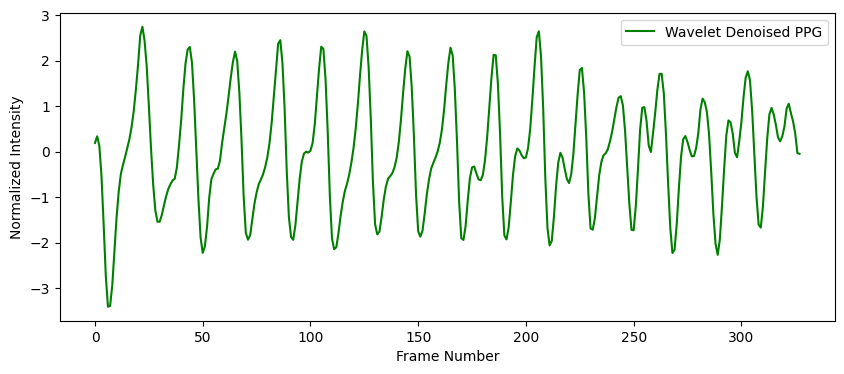

In [584]:
import pywt
import numpy as np

def wavelet_denoise(signal, wavelet='db4', level=2):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[1:] = [pywt.threshold(c, np.std(c)/3, mode='soft') for c in coeffs[1:]]  
    return pywt.waverec(coeffs, wavelet)

# Apply wavelet denoising to your PPG signal
ppg_denoised = wavelet_denoise(filtered_ppg, wavelet='db4', level=2)

# Plot denoised signal
plt.figure(figsize=(10, 4))
plt.plot(ppg_denoised, label="Wavelet Denoised PPG", color="green")
plt.xlabel("Frame Number")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.show()


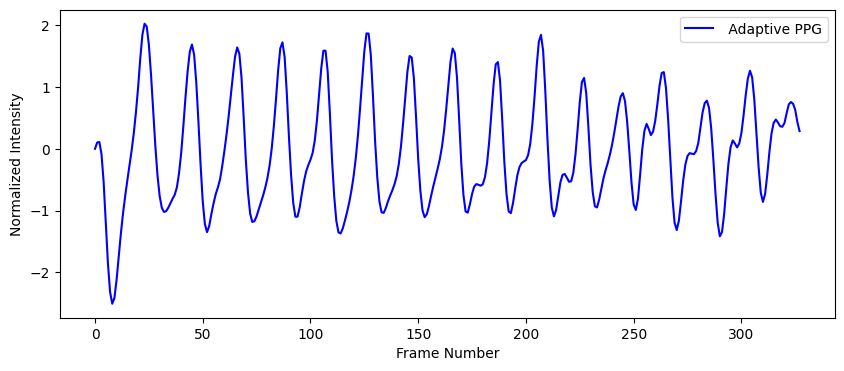

In [585]:
from scipy.signal import lfilter

def adaptive_filter(signal, alpha=0.7):  # Reduce alpha
    filtered_signal = np.zeros_like(signal)
    for i in range(1, len(signal)):
        filtered_signal[i] = alpha * filtered_signal[i-1] + (1-alpha) * signal[i]
    return filtered_signal


# Apply adaptive filtering
ppg_filtered = adaptive_filter(ppg_denoised)

# Plot denoised signal
plt.figure(figsize=(10, 4))
plt.plot(ppg_filtered, label=" Adaptive PPG", color="blue")
plt.xlabel("Frame Number")
plt.ylabel("Normalized Intensity")
plt.legend()
plt.show()


In [586]:
# Ensure the processed PPG signal is within the same range as training data
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import pickle

# Load the same scaler used during training
with open("glucose_ensemble/scaler_y.pkl", "rb") as f:
    scaler_X = pickle.load(f)

filtered_ppg_normalized = scaler_X.transform(ppg_filtered.reshape(-1, 1)).flatten()


In [587]:
# Ensure correct input shape
X_unseen = np.expand_dims(filtered_ppg_normalized, axis=-1)  # Should be (625, 1)

# Check input shape
print(f"Shape before trimming: {X_unseen.shape}")

# Trim or pad the sequence if needed
expected_length = 302  # Change this if your model expects a different length
if X_unseen.shape[0] > expected_length:
    X_unseen = X_unseen[:expected_length]  # Trim to match expected shape
elif X_unseen.shape[0] < expected_length:
    X_unseen = np.pad(X_unseen, ((0, expected_length - X_unseen.shape[0]), (0, 0)), mode='constant')

# Reshape for LSTM input
X_unseen = np.expand_dims(X_unseen, axis=0)  # Add batch dimension

print(f"Shape after reshaping: {X_unseen.shape}")  # Should be (1, 302, 1)


Shape before trimming: (328, 1)
Shape after reshaping: (1, 302, 1)


In [588]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

In [589]:
def load_ensemble_model(metadata_path):
    """
    Load an ensemble of models along with the scaler used for the target variable.
    
    Parameters:
    -----------
    metadata_path : str
        Path to the metadata file
    
    Returns:
    --------
    models : list
        List of loaded Keras models
    scaler_y : object
        The scaler used to transform the target variable
    """
    # Load metadata
    with open(metadata_path, 'rb') as f:
        metadata = pickle.load(f)
    
    # Load models
    models = []
    for model_path in metadata['model_paths']:
        model = load_model(model_path)
        models.append(model)
    
    # Load scaler
    with open(metadata['scaler_path'], 'rb') as f:
        scaler_y = pickle.load(f)
    
    print(f"Loaded ensemble with {len(models)} models")
    return models, scaler_y

In [590]:
# import numpy as np
# import scipy.signal as signal
# import matplotlib.pyplot as plt

# # Function to compute Signal-to-Noise Ratio (SNR)
# def compute_snr(ppg_signal):
#     signal_power = np.mean(ppg_signal ** 2)
#     noise_power = np.mean((ppg_signal - np.mean(ppg_signal)) ** 2)
#     snr = 10 * np.log10(signal_power / noise_power)
#     return snr

# # Function to detect peaks (Heart Rate Check)
# def detect_peaks(ppg_signal, fs=30):
#     peaks, _ = signal.find_peaks(ppg_signal, distance=fs/2)  # Assuming heart rate ~60-100 bpm
#     return len(peaks) / (len(ppg_signal) / fs) * 60  # Convert to BPM

# # Function to compute Power Spectral Density (PSD)
# def compute_psd(ppg_signal, fs=30):
#     freqs, psd = signal.welch(ppg_signal, fs=fs, nperseg=fs*4)
#     return freqs, psd

# # Function to compute Coefficient of Variation (CV)
# def compute_cv(ppg_signal):
#     return np.std(ppg_signal) / np.mean(ppg_signal)

# # Load your PPG signal (replace with actual data)
# ppg_signal = ppg_filtered  # Use your preprocessed PPG signal
# fs = 30  # Sampling rate (30 Hz)

# # Compute signal stability metrics
# snr = compute_snr(ppg_signal)
# heart_rate = detect_peaks(ppg_signal, fs)
# cv = compute_cv(ppg_signal)
# freqs, psd = compute_psd(ppg_signal, fs)

# # Display results
# print(f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB")
# print(f"Estimated Heart Rate: {heart_rate:.1f} BPM")
# print(f"Coefficient of Variation (CV): {cv:.3f}")

# # Plot PPG waveform
# plt.figure(figsize=(10, 4))
# plt.plot(ppg_signal, label="PPG Signal", color='blue')
# plt.xlabel("Time (samples)")
# plt.ylabel("Amplitude")
# plt.title("PPG Signal Stability Analysis")
# plt.legend()
# plt.show()

# # Plot Power Spectral Density
# plt.figure(figsize=(8, 4))
# plt.semilogy(freqs, psd, color='red')
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Power Spectral Density")
# plt.title("PPG Signal Frequency Analysis")
# plt.show()


In [591]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

In [592]:
def ensemble_predict(models, X_test):
    X_test = np.expand_dims(X_test, axis=-1)  # Ensure correct shape for LSTM
    predictions = np.array([model.predict(X_test) for model in models])  # Get predictions from all models
    final_predictions = np.mean(predictions, axis=0)  # Average predictions
    return final_predictions.flatten()

# Load the ensemble model and scaler
metadata_path = 'glucose_ensemble/metadata.pkl'
loaded_models, loaded_scaler_y = load_ensemble_model(metadata_path)

# Predict glucose level
y_pred = ensemble_predict(loaded_models, X_unseen)

# Convert predictions back to original glucose scale
y_pred_original = loaded_scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"Predicted Blood Glucose Level: {y_pred_original[0]:.2f} mg/dL")


Loaded ensemble with 3 models
1/1 [==============================] - 1s 1s/step
Predicted Blood Glucose Level: 122.30 mg/dL


In [593]:
# import tensorflow as tf

# model_paths = ["glucose_ensemble/model_1.h5", "glucose_ensemble/model_2.h5", "glucose_ensemble/model_3.h5"]
# tflite_paths = ["glucose_ensemble/model_1.tflite", "glucose_ensemble/model_2.tflite", "glucose_ensemble/model_3.tflite"]

# for i in range(len(model_paths)):
#     model = tf.keras.models.load_model(model_paths[i])
#     converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
#     # Enable TensorFlow ops compatibility
#     converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,  
#                                            tf.lite.OpsSet.SELECT_TF_OPS]  
#     converter._experimental_lower_tensor_list_ops = False  # Fix TensorListReserve issue
#     converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optimize for mobile

#     tflite_model = converter.convert()

#     with open(tflite_paths[i], "wb") as f:
#         f.write(tflite_model)
    
#     print(f"✅ {tflite_paths[i]} saved successfully!")
